# Pruned Monte-Carlo

* Cでシュミレーションだけやってしまう

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import random
import time
from collections import deque
from InfMaxProblem import Monte_Carlo as mc

%matplotlib inline

In [122]:
# 入力は隣接リスト(numpy)[[from_node, to_node, edge_prob],...]
def live_edge_graph_edges(p, p_len):
    rand = np.random.uniform(0, 1, p_len)
    prob = p.T[2]
    l = np.where(rand < prob)[0]
    return np.array([[p[i][0], p[i][1]] for i in l])

# %time live_edge_graph_edges(network_np, len(network_np))
# Wall time: 86.1 ms

In [4]:
# 幅優先探索によって、Sから到達可能なノードを返す
def bfs(G, S):
    visited = {s:None for s in S}
    queue = deque(S)
    while queue:
        v = queue.popleft()
        out_node = G.successors(v)
        for u in out_node:
            if not (u in visited):
                queue.append(u)
                visited[u] = v
    return visited

In [5]:
# 幅優先探索によって、Sから到達可能なノードを返す
def bfs_reverse(G, S):
    visited = {s:None for s in S}
    queue = deque(S)
    while queue:
        v = queue.popleft()
        in_node = G.predecessors(v)
        for u in in_node:
            if not (u in visited):
                queue.append(u)
                visited[u] = v
    return visited

In [6]:
# 強連結成分分解に使うための関数
def dfs_go(G):
    visited = dict([])
    # vs:帰りがけ順
    vs = deque([])
    for s in G.nodes():
        if s not in visited:
            visited[s] = None
            Stack = deque([s])
            vs_tmp = deque([s])
            while Stack:
                v = Stack.pop()
                #if v not in vs_tmp:
                vs_tmp.appendleft(v)
                out_node = G[v]
                for u in out_node:
                    if u not in visited:
                        visited[u] = s
                        Stack.append(u)
            #vs = vs_tmp + vs
            vs.extendleft(vs_tmp)
    return visited, vs

# 強連結成分分解に使うための関数
def dfs_back(G, vs):
    group = dict([])
    group_num = 0
    DAG = nx.DiGraph()
    for s in vs:
        if s not in group:
            w = 1
            Stack = deque([s])
            members = []
            while Stack:
                v = Stack.pop()
                members.append(v)
                group[v] = group_num
                in_node = G.predecessors(v)
                for u in in_node:
                    if u not in group:
                        group[u] = group_num
                        w += 1
                        Stack.append(u)
                    else:
                        if group_num !=  group[u]:
                            DAG.add_edge(group[u], group_num)
            DAG.add_node(group_num, weight=w, members=members)
            group_num += 1
    return group, DAG

def scc_DAG(G):
    visited ,vs = dfs_go(G)
    group, DAG = dfs_back(G, vs)
    return group, DAG

In [7]:
# i回目のシュミレーションでv_Vが到達できる頂点数
def GAIN(i, v_V, comp, G, A, S, h, D, V):
    if v_V not in comp[i]:
        return 0        
        
    # v:i回目のシュミレーションで作成されたグラフのv_Vを含む強連結成分
    v = comp[i][v_V]
    
    # V[i]にvがない場合0(後に消されていくため)
    if v not in V:
        delta[i][v] = 0
        return 0
    
    # delta
    if latest[i][v]:
        return delta[i][v]
        
    latest[i][v] = True
    
    # len(S)==0の理由は初回のみ行えば良いため(h(ハブ)以降の到達頂点数は一回行えば十分であるため)
    # vがhのacestorだった場合、hの到達頂点数を計算して、他のacestorの時にも使い回す
    if (v in A[i]) and (len(S) == 0):
        # GAINの引数は後で変える
        # hのGAINをはじめから足しておく
        h_Vs = G[i].nodes[h[i]]["members"]
        delta[i][v] = GAIN(i, h_Vs[0], comp, G, A, S, h, D, V)
    else:
        delta[i][v] = 0
    
    # bfs
    Q = deque([v])
    # Xは探索済みの強連結成分
    X = set([v])
    while Q:
        u = Q.popleft()
        
        if (v in A[i]) and (u in D[i]) and (len(S) == 0):
            continue
            
        delta[i][v] += G[i].nodes[u]["weight"]
        
        
        Edges = G[i].out_edges(u)
        for u_, w in Edges:
            # 探索済みの強連結成分は探索しなくていいので、w not in X
            # w in V[i]はのちのupdateでV[i]が変化するため
            if (w not in X) and (w in V):
                Q.append(w)
                X.add(w)
        
    return delta[i][v]

In [8]:
def UPDATEDAG(i, t_V, comp, G):
    if t_V not in comp[i]:
        return G[i]
    
    # t:DAG上でのノードid
    t = comp[i][t_V]
    
    if t in G[i]:
        # t -> u
        u = list(bfs(G[i], [t]))
        # u = list(dict(nx.bfs_edges(G[i], t)))
        # v -> u:上で求めたuにだどりつくvを求める
        v = set(bfs_reverse(G[i], u))

        # v かつ Viに存在する頂点
        v_ = list(v & set(G[i].nodes()))
        latest[i].update(zip(v_, [False]*len(v_)))

        G[i].remove_nodes_from(u)
        return G[i]
    else:
        return G[i]

In [9]:
def PMC_greedy(network_np, k, R):
    time_list = []
    # E_ = dict([])
    # G_ = dict([])
    G = dict([])
    comp = dict([])
    h = dict([])
    D = dict([])
    A = dict([])
    V = dict([])
    global latest
    latest = dict([])
    global delta
    delta = {i:dict([]) for i in range(R)}
    
    # 全体のグラフ
    Node = np.unique(network_np.T[[0,1]])
    
    # 元グラフの頂点集合
    G_V = [int(node) for node in Node]
    
    # copy用に作っておく
    G_copy = nx.DiGraph()
    G_copy.add_nodes_from(G_V)
    
    for i in tqdm(range(R)):
        
        E_ = live_edge_graph_edges(network_np, len(network_np))
        
        G_ = G_copy.copy()
        G_.add_edges_from(E_)
        
        comp[i], G[i] = scc_DAG(G_)
        
        G_i_deg = dict(G[i].degree())
        h[i] = max(G_i_deg, key=G_i_deg.get)
        
        D[i] = set(bfs(G[i], [h[i]]))
        
        A[i] = set(bfs_reverse(G[i], [h[i]])) - set([h[i]])
        
        V[i] = G[i].nodes()
        latest[i] = {v:False for v in V[i]}
    print("comp init")
    
    S = []
    for j in range(k):
        start = time.time()
        v_gain = {v:sum([GAIN(i, v, comp, G, A, S, h, D, G[i].nodes()) for i in range(R)])/R for v in tqdm(G_V)}

        t = max(v_gain, key=v_gain.get)
        
        S.append(t)
        
        for i in range(R):
            G[i] = UPDATEDAG(i, t, comp, G)
        time_list.append(time.time())
        
    return S

In [10]:
# k = 5
# R = 200
# %time PMC_greedy(network_np, k, R)

# CPU times: user 16min, sys: 9min 10s, total: 25min 10s
# Wall time: 32min 56s
# [763, 645, 634, 71399, 3924]

In [11]:
# G = nx.DiGraph()
# G.add_weighted_edges_from(network_np)

In [12]:
# %time mc.approx_inf_size_IC_T(G, [0, 1, 29, 27, 26], 10000)

In [13]:
# # 枝確率を計算済みのネットワークを読み込む
# network = pd.read_csv("data/Epinions/WC_small.csv")
# network.head()

# # numpy型に変換
# network_np = network.values

In [14]:
# G_small = nx.DiGraph()

# G_small.add_weighted_edges_from(network_np)

# plt.figure(figsize=(15,10))
# nx.draw_networkx(G_small)
# plt.show()

# PMC_greedy(network_np, 20, 2)

# 計算実験

In [21]:
def PMC_greedy_time(network_np, k, R):
    time_list = []
    # E_ = dict([])
    # G_ = dict([])
    G = dict([])
    comp = dict([])
    h = dict([])
    D = dict([])
    A = dict([])
    V = dict([])
    global latest
    latest = dict([])
    global delta
    delta = {i:dict([]) for i in range(R)}
    G_V = set([])
    
    for i in tqdm(range(R)):
        
        E_ = live_edge_graph_edges(network_np, len(network_np))
        
        # 枝が伸びている頂点集合
        G_V |= set(np.unique(E_.T[[0,1]]))
        
        G_ = nx.DiGraph()
        G_.add_edges_from(E_)
        
        comp[i], G[i] = scc_DAG(G_)
        
        G_i_deg = dict(G[i].degree())
        h[i] = max(G_i_deg, key=G_i_deg.get)
        
        D[i] = set(bfs(G[i], [h[i]]))
        
        A[i] = set(bfs_reverse(G[i], [h[i]])) - set([h[i]])
        
        V[i] = G[i].nodes()
        latest[i] = {v:False for v in V[i]}
    print("comp init")
    
    S = []
    for j in range(k):
        start = time.time()
        v_gain = {v:sum([GAIN(i, v, comp, G, A, S, h, D, G[i].nodes()) for i in range(R)])/R for v in tqdm(G_V)}
        
        """
        v_gain = dict([])
        for v in tqdm(G_V):
            wa = 0
            start = time.time()
            for i in range(R):
                
                wa += GAIN(i, v, comp, G, A, S, h, D, G[i].nodes())
                
            v_gain[v] = wa / R
            end = time.time()
            if end - start > 1:
                print(i, v, v in A[i])
        """
        
        
        t = max(v_gain, key=v_gain.get)
        
        S.append(t)
        
        for i in range(R):
            G[i] = UPDATEDAG(i, t, comp, G)
        time_list.append(time.time()-start)
        
    return S, time_list

## Epinions

In [66]:
run_time = dict([])
S = dict([])

### WC

In [67]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/WC.csv")
network.head()

,# FromNodeId,ToNodeId,WC
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [68]:
# numpy型に変換
network_np = network.values

In [69]:
start = time.time()
S["WC"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["WC"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [70]:
WC_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
WC_df_seed_time.to_csv("WC_df_seed_time.csv")

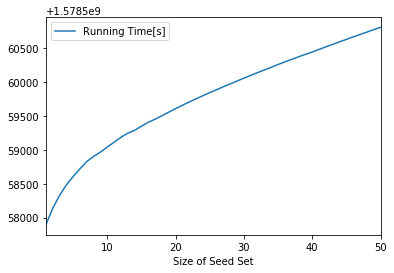

In [71]:
WC_df_seed_time.plot()

In [72]:
WC_df_seed_time.iloc[0][0]

1578557892.8218937

In [73]:
run_time["WC"]
# 2870.9144158363342

3648.3582606315613

In [74]:
S["WC"]

# [763,
#  634,
#  645,
#  71399,
#  5232,
#  3924,
#  637,
#  2969,
#  1835,
#  145,
#  44,
#  1059,
#  2066,
#  1669,
#  824,
#  1172,
#  5227,
#  1539,
#  2118,
#  5144,
#  1596,
#  2704,
#  1225,
#  4931,
#  1501,
#  546,
#  629,
#  9412,
#  1720,
#  1409,
#  661,
#  1533,
#  1638,
#  5224,
#  3850,
#  6003,
#  3952,
#  5905,
#  1849,
#  751,
#  71388,
#  1626,
#  1189,
#  7427,
#  6489,
#  426,
#  7047,
#  3065,
#  3234,
#  770]

[763.0,
 634.0,
 645.0,
 5232.0,
 71399.0,
 3924.0,
 1835.0,
 5227.0,
 637.0,
 2969.0,
 1059.0,
 145.0,
 4920.0,
 2066.0,
 1225.0,
 7047.0,
 1720.0,
 2704.0,
 1596.0,
 9412.0,
 1539.0,
 5224.0,
 1669.0,
 629.0,
 1533.0,
 44.0,
 5144.0,
 824.0,
 6003.0,
 770.0,
 1172.0,
 6774.0,
 2118.0,
 1409.0,
 3850.0,
 71388.0,
 1501.0,
 3527.0,
 16248.0,
 661.0,
 7392.0,
 4931.0,
 650.0,
 5382.0,
 546.0,
 6489.0,
 3415.0,
 1727.0,
 7394.0,
 7687.0]

### TR

In [75]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/TR.csv")
network.head()

,# FromNodeId,ToNodeId,TR
0,0,4,0.10
1,0,5,0.01
2,0,7,0.10
3,0,8,0.01
4,0,9,0.10


In [76]:
# numpy型に変換
network_np = network.values

In [77]:
start = time.time()
S["TR"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["TR"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [78]:
TR_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
TR_df_seed_time.to_csv("TR_df_seed_time.csv")

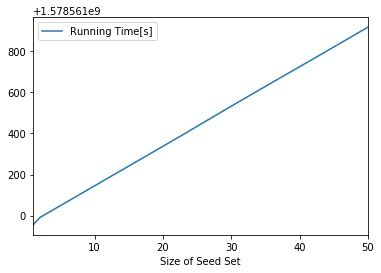

In [79]:
TR_df_seed_time.plot()

In [80]:
run_time["TR"]
# 14991.995094537735

1095.2443714141846

In [81]:
S["TR"]
# [5175,
#  3805,
#  1209,
#  4077,
#  5432,
#  962,
#  12948,
#  622,
#  4154,
#  5803,
#  1805,
#  6529,
#  762,
#  9419,
#  3023,
#  4092,
#  1643,
#  183,
#  3987,
#  4716,
#  10070,
#  2200,
#  7642,
#  8975,
#  188,
#  6701,
#  7544,
#  19561,
#  5752,
#  178,
#  260,
#  459,
#  2274,
#  2199,
#  10997,
#  591,
#  1931,
#  3778,
#  4832,
#  950,
#  572,
#  19583,
#  3515,
#  246,
#  3519,
#  5832,
#  71401,
#  821,
#  5359,
#  2736]

[5232.0,
 1669.0,
 770.0,
 1835.0,
 3924.0,
 1720.0,
 6036.0,
 7427.0,
 1059.0,
 3952.0,
 1847.0,
 4920.0,
 11581.0,
 5425.0,
 4092.0,
 1727.0,
 6774.0,
 5224.0,
 12776.0,
 7047.0,
 7392.0,
 16248.0,
 71399.0,
 1851.0,
 5503.0,
 1189.0,
 1447.0,
 1209.0,
 3865.0,
 6508.0,
 5382.0,
 7592.0,
 6003.0,
 50959.0,
 2410.0,
 12810.0,
 3531.0,
 1805.0,
 5113.0,
 7421.0,
 600.0,
 3805.0,
 763.0,
 4918.0,
 1450.0,
 3519.0,
 616.0,
 5791.0,
 831.0,
 3220.0]

### P=0.1

In [82]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_1.csv")
network.head()

,# FromNodeId,ToNodeId,P=0.1
0,0,4,0.1
1,0,5,0.1
2,0,7,0.1
3,0,8,0.1
4,0,9,0.1


In [83]:
# numpy型に変換
network_np = network.values

In [84]:
start = time.time()
S["P=0_1"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["P=0_1"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [85]:
P01_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P01_df_seed_time.to_csv("P01_df_seed_time.csv")

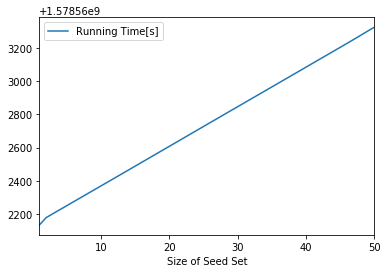

In [86]:
P01_df_seed_time.plot()

In [87]:
run_time["P=0_1"]

1406.3935327529907

In [88]:
S["P=0_1"]

[11581.0,
 7592.0,
 44812.0,
 4920.0,
 11780.0,
 31923.0,
 18693.0,
 9057.0,
 23827.0,
 24644.0,
 27765.0,
 6931.0,
 32367.0,
 3227.0,
 1869.0,
 50268.0,
 9419.0,
 9164.0,
 27084.0,
 12231.0,
 9827.0,
 6769.0,
 20680.0,
 5975.0,
 19859.0,
 16310.0,
 15624.0,
 14459.0,
 24283.0,
 6013.0,
 9739.0,
 1209.0,
 4209.0,
 5090.0,
 48460.0,
 24540.0,
 19104.0,
 69187.0,
 19406.0,
 33240.0,
 13260.0,
 3161.0,
 5639.0,
 5384.0,
 5435.0,
 11801.0,
 4160.0,
 19849.0,
 7393.0,
 7971.0]

### P=0.01

In [89]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_01.csv")
network.head()

,# FromNodeId,ToNodeId,P=0.01
0,0,4,0.01
1,0,5,0.01
2,0,7,0.01
3,0,8,0.01
4,0,9,0.01


In [90]:
# numpy型に変換
network_np = network.values

In [91]:
start = time.time()
S["P=0_01"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["P=0_01"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [92]:
P001_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P001_df_seed_time.to_csv("P001_df_seed_time.csv")

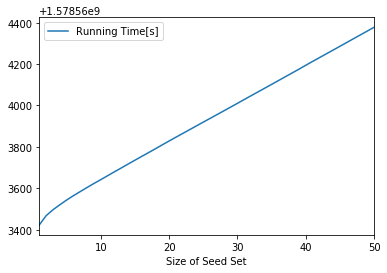

In [93]:
P001_df_seed_time.plot()

In [94]:
run_time["P=0_01"]

1052.205108165741

In [95]:
S["P=0_01"]

[645.0,
 634.0,
 763.0,
 71399.0,
 145.0,
 3924.0,
 1059.0,
 637.0,
 5232.0,
 1225.0,
 661.0,
 1669.0,
 44.0,
 824.0,
 3850.0,
 1835.0,
 629.0,
 279.0,
 2704.0,
 1379.0,
 770.0,
 1720.0,
 1501.0,
 1596.0,
 1727.0,
 7427.0,
 1626.0,
 492.0,
 4929.0,
 2969.0,
 1636.0,
 1638.0,
 119.0,
 5227.0,
 2279.0,
 652.0,
 1539.0,
 1494.0,
 3234.0,
 5224.0,
 4017.0,
 4010.0,
 1847.0,
 590.0,
 6467.0,
 1476.0,
 2729.0,
 481.0,
 650.0,
 2277.0]

### P=0.001

In [96]:
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data/Epinions/P=0_001.csv")
network.head()

,# FromNodeId,ToNodeId,P=0.001
0,0,4,0.001
1,0,5,0.001
2,0,7,0.001
3,0,8,0.001
4,0,9,0.001


In [97]:
# numpy型に変換
network_np = network.values

In [98]:
start = time.time()
S["P=0_001"], time_list = PMC_greedy_time(network_np, 50, 200)
run_time["P=0_001"] = time.time() - start

/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



comp init


/home/fueki/anaconda3/envs/all/lib/python3.7/site-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [99]:
P0001_df_seed_time = pd.DataFrame({"Size of Seed Set":range(1,51), 
                                "Running Time[s]":time_list}).set_index("Size of Seed Set")
P0001_df_seed_time.to_csv("P0001_df_seed_time.csv")

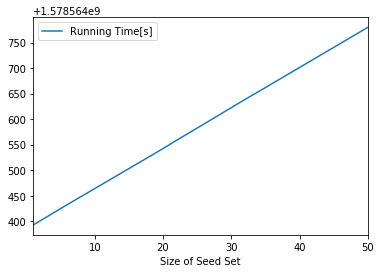

In [100]:
P0001_df_seed_time.plot()

In [101]:
run_time["P=0_001"]

401.0468604564667

In [102]:
S["P=0_001"]

[645.0,
 763.0,
 634.0,
 71399.0,
 3924.0,
 44.0,
 5232.0,
 1059.0,
 637.0,
 34.0,
 737.0,
 1835.0,
 824.0,
 145.0,
 1225.0,
 1.0,
 770.0,
 1516.0,
 2066.0,
 1596.0,
 31.0,
 27.0,
 2969.0,
 1720.0,
 18.0,
 661.0,
 725.0,
 5227.0,
 1669.0,
 143.0,
 3850.0,
 590.0,
 738.0,
 35.0,
 546.0,
 2118.0,
 2704.0,
 492.0,
 418.0,
 443.0,
 629.0,
 7427.0,
 1396.0,
 1727.0,
 40.0,
 735.0,
 918.0,
 1172.0,
 1626.0,
 1409.0]

# 結果

In [103]:
pd.DataFrame(S)

,WC,TR,P=0_1,P=0_01,P=0_001
0,763.0,5232.0,11581.0,645.0,645.0
1,634.0,1669.0,7592.0,634.0,763.0
2,645.0,770.0,44812.0,763.0,634.0
3,5232.0,1835.0,4920.0,71399.0,71399.0
4,71399.0,3924.0,11780.0,145.0,3924.0
5,3924.0,1720.0,31923.0,3924.0,44.0
6,1835.0,6036.0,18693.0,1059.0,5232.0
7,5227.0,7427.0,9057.0,637.0,1059.0
8,637.0,1059.0,23827.0,5232.0,637.0
9,2969.0,3952.0,24644.0,1225.0,34.0


In [104]:
pd.DataFrame([run_time])

,WC,TR,P=0_1,P=0_01,P=0_001
0,3648.358261,1095.244371,1406.393533,1052.205108,401.04686


In [106]:
# resultフォルダに保存
pd.DataFrame(S).to_csv("result/Epinions/seed.csv")
pd.DataFrame([run_time]).to_csv("result/Epinions/run_time.csv")